In [74]:
# Import math and statistics libraries
import numpy as np

# Import data manipulation libraries
import pandas as pd

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import system libraries
import os
import sys
from dotenv import load_dotenv

# # Import Polygon.io client for financial data
# from polygon import RESTClient

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from os_lib import OSLib # type: ignore
# from polygon_api import PolygonAPI

In [75]:
# Get the API key from environment variables
load_dotenv()
api_key = os.getenv('POLYGON_API_KEY')

In [76]:
# # Import Polygon.io client for financial data
# from polygon import RESTClient
# import time

# ind_ticks = ['I:NDX', 'I:COMP'] # NDX = NASDAQ-100 - COMP = NASDAQ-Composite
# not_authorized = ['I:SPX', 'I:DJI'] # SPX = S&P500 - DJI = Dow Jones Industrial Average


# client = RESTClient(api_key)
# for ind_tick in ind_ticks:
#     for a in client.list_aggs(
#         ticker=ind_tick,
#         multiplier=1,
#         timespan='day',
#         from_='2023-01-01',
#         to='2023-12-31',
#         limit=1000):
#         print(a)
#         print(f"{ind_tick}: run complete")
#         time.sleep(0.25)
#         break

In [77]:
# Tickers from a selection of the S&P 500 companies
tickers = ['AAPL', 'MSFT', 'GOOGL', 'IBM', 'AMZN', 'NVDA',
          'XOM', 'CVX', 'WMT', 'MMM', 'ARE', 'ALLE', 'JPM',
          'V', 'MA', 'PEP', 'CSCO', 'BA', 'ADBE', 'CAT', 
          'BLK', 'INTC', 'NKE', 'MDLZ']

In [78]:
indices = ['I:NDX', 'I:COMP',
           #'I:SPX', 'I:DJI'
           ]

In [79]:
# Import custom lib
oslib = OSLib

# Get the root path of the repository
repo_path = oslib.get_root_path()


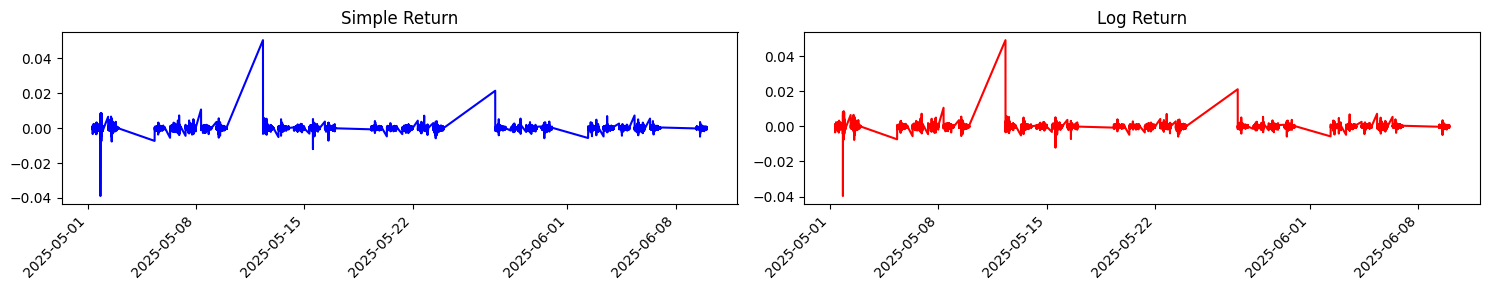

Simple Return: 0.00066 %
Log Return: 0.00062 %


In [80]:
source_path = repo_path + "/data/polygon/intraday/amzn/"

amzn = pd.read_parquet(source_path)
amzn.sort_index(inplace=True)

amzn['simple_return'] = (amzn['close'] / amzn['close'].shift(1)) - 1
amzn['log_return'] = np.log(amzn['close'] / amzn['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn['log_return'].mean() * 100, 5)} %")

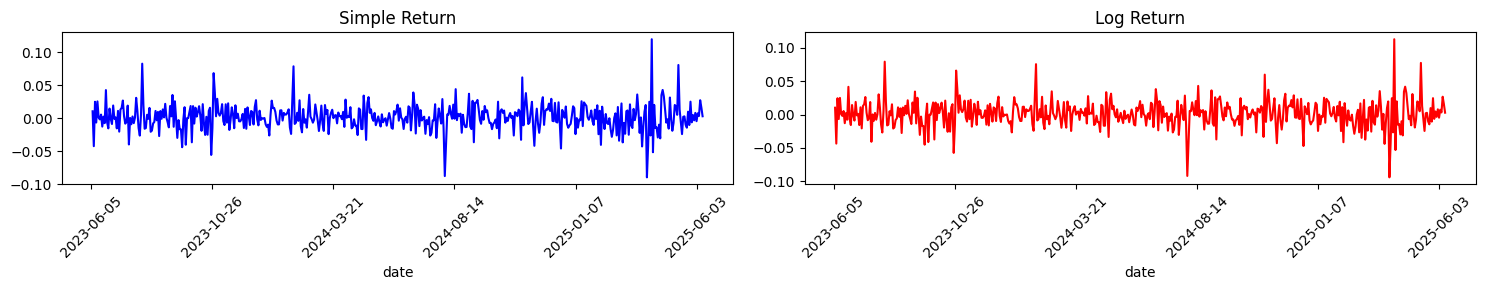

Simple Return: 0.1289 %
Log Return: 0.10931 %


In [81]:
source_path = repo_path + "/data/polygon/daily/amzn/"

amzn_daily = pd.read_parquet(source_path)
amzn_daily.index = pd.to_datetime(amzn_daily.index).strftime('%Y-%m-%d')

amzn_daily['simple_return'] = (amzn_daily['close'] / amzn_daily['close'].shift(1)) - 1

amzn_daily['log_return'] = np.log(amzn_daily['close'] / amzn_daily['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn_daily['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn_daily['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn_daily['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn_daily['log_return'].mean() * 100, 5)} %")

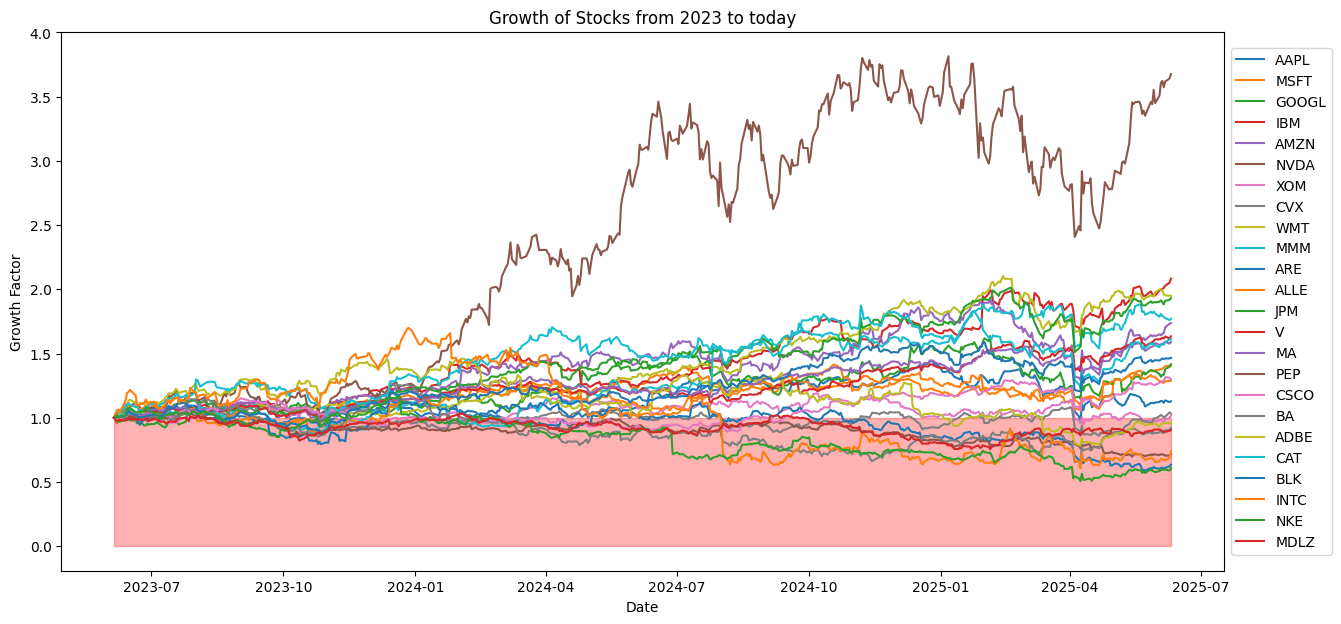

In [82]:
source_daily_path = repo_path + "/data/polygon/daily/"


df = pd.DataFrame()
simple_returns = pd.DataFrame()

plt.figure(figsize=(15, 7))

for ticker in tickers:
    df[ticker] = pd.read_parquet(source_daily_path + ticker.lower() + "/")['close']
    simple_returns[ticker] = (df[ticker] / df[ticker].shift(1)) - 1
    growth = (df[ticker] / df[ticker].iloc[0])
    plt.plot(df.index, growth, label=ticker.upper())

thres = 1.0

plt.fill_between(df.index, thres, 0, where=(df[ticker] > thres), color='red', alpha=0.3)
plt.title('Growth of Stocks from 2023 to today')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

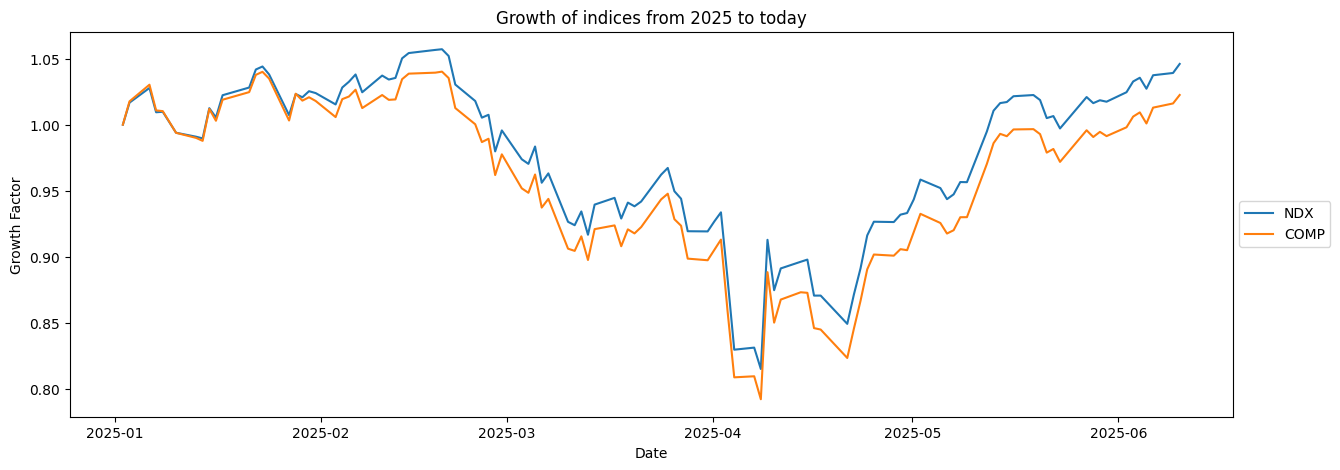

In [100]:
idx_source_daily_path = repo_path + "/data/polygon/daily/index/"


ind_df = pd.DataFrame()
ind_returns = pd.DataFrame()

plt.figure(figsize=(15, 5))

for tick in indices:
    ticker = tick.split(':')[1]  # Extract the ticker symbol from the index
    ind_df[ticker] = pd.read_parquet(idx_source_daily_path + ticker.lower() + "/")['close']
    ind_returns[ticker] = (ind_df[ticker] / ind_df[ticker].shift(1)) - 1
    growth = (ind_df[ticker] / ind_df[ticker].iloc[0])
    plt.plot(ind_df.index, growth, label=ticker.upper())

thres = 1.0

# plt.fill_between(ind_df.index, thres, where=(ind_df[ticker] > thres), color='red', alpha=0.3)
plt.title('Growth of indices from 2025 to today')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

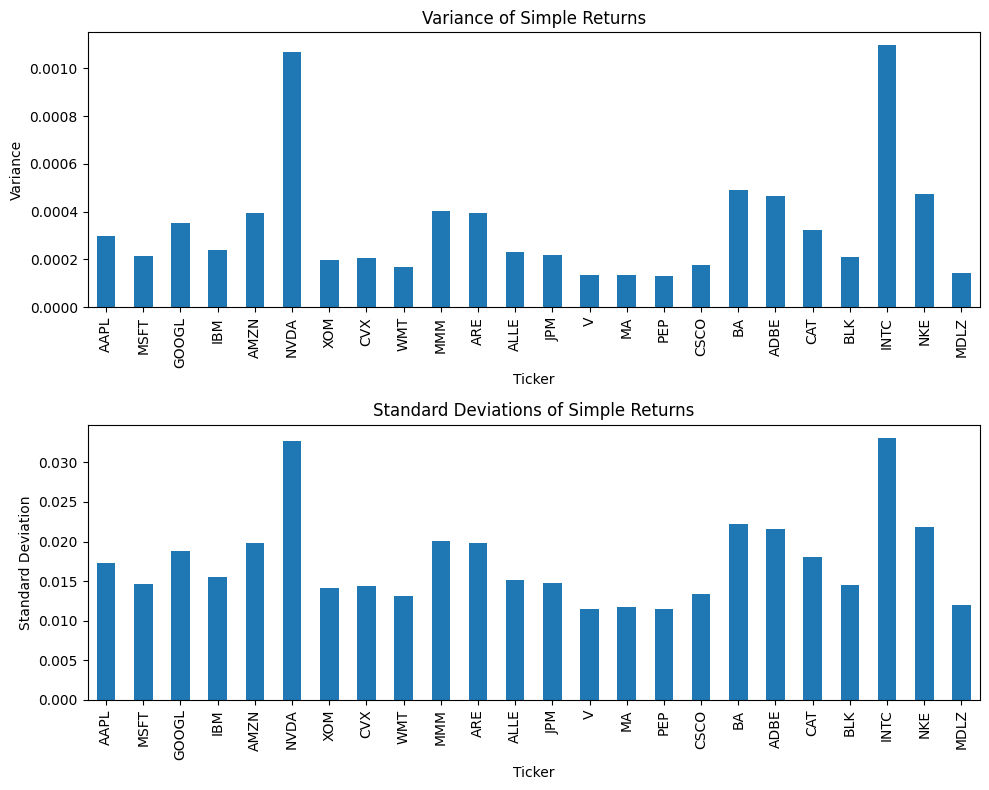

In [101]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
simple_returns.var().plot(kind='bar', ax=axs[0], title='Variance of Simple Returns')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Variance')

# Plot standard deviation of returns
simple_returns.std().plot(kind='bar', ax=axs[1], title='Standard Deviations of Simple Returns')
axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Standard Deviation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<Axes: >

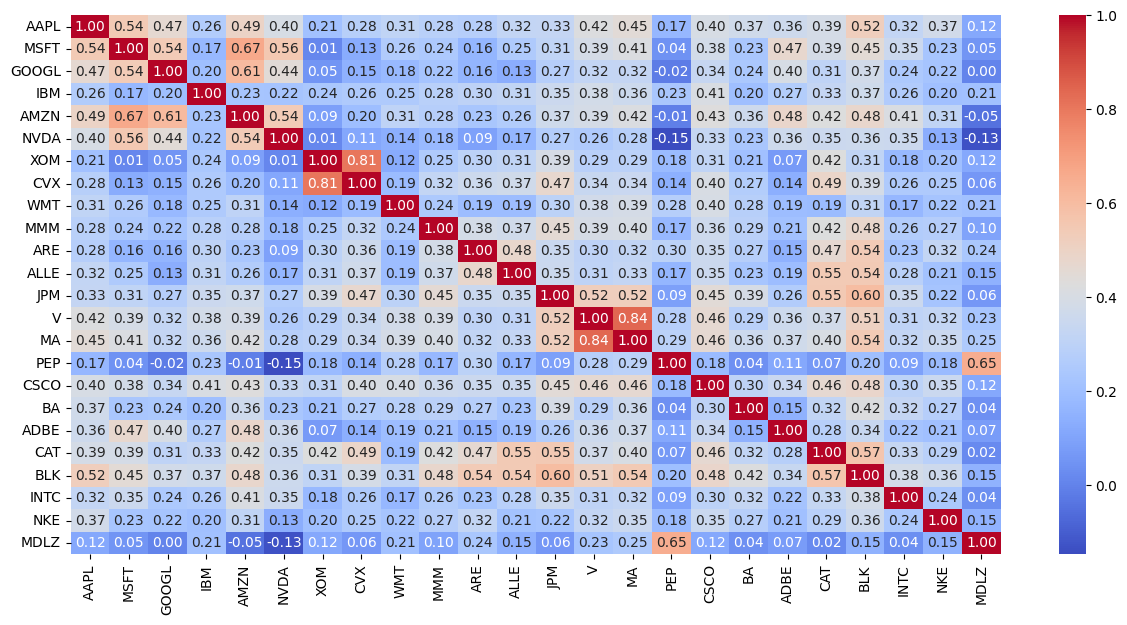

In [102]:
plt.figure(figsize=(15, 7))
sns.heatmap(simple_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [103]:
# Setting weight for equal distribution among tickers
equal_ws = np.array([1/len(tickers) for _ in tickers])

In [104]:
pfolio_returns = simple_returns.dot(equal_ws)
pfolio_var = np.dot(equal_ws.T, np.dot(simple_returns.cov(), equal_ws))
print(f"Portfolio Returns: {round(pfolio_returns.mean() * 100, 5)} %")
print(f"Portfolio Variance: {pfolio_var}")

Portfolio Returns: 0.0654 %
Portfolio Variance: 9.93889824287e-05


## Aggregate DataFrame

### Dividend Yield & Returns in 2024

In [105]:
source_dividends_path = repo_path + "/data/polygon/dividends/"
divs = pd.read_parquet(source_dividends_path)

# Calculate average dividend payout per share per ticker in 2024
sum_divs = divs[(divs.index >= '2024-01-01') & (divs.index < '2025-01-01')][['ticker', 'cash_amount']].groupby('ticker').sum()
sum_divs = sum_divs.rename(columns={'cash_amount': 'total_dividend_2024'})

In [106]:
# Calculate the average share price for each ticker in 2024
avg_price_df = pd.DataFrame()

for ticker in os.listdir(source_daily_path):
    ticker_df = pd.read_parquet(source_daily_path + ticker + "/")
    avg_price_2024 = ticker_df[(ticker_df.index >= '2024-01-01') & (ticker_df.index < '2025-01-01')]['close'].mean()
    avg_price_df.loc[ticker.upper(), 'avg_price_2024'] = avg_price_2024
    avg_price_df.loc[ticker.upper(), 'returns_2024_%'] = (ticker_df['close'].iloc[-1] / ticker_df['close'].iloc[0]) - 1

In [107]:
# join the dfs on the index
agg_12mnd_df = sum_divs.join(avg_price_df, how='inner')

# Calculate the dividend yield for each ticker
agg_12mnd_df['dividend_yield_%_2024'] = (agg_12mnd_df['total_dividend_2024'] / agg_12mnd_df['avg_price_2024']) * 100

agg_12mnd_df.sort_values(by='dividend_yield_%_2024', ascending=False).head(10)

,total_dividend_2024,avg_price_2024,returns_2024_%,dividend_yield_%_2024
ARE,5.19,117.724762,-0.364723,4.408588
CVX,6.52,153.067937,-0.078194,4.259547
IBM,6.67,193.956389,1.082630,3.438917
XOM,3.84,113.476548,0.018330,3.383959
MMM,3.61,108.840254,0.770685,3.316788
PEP,5.33,169.141111,-0.284272,3.151215
CSCO,1.59,50.803730,0.297550,3.129691
MDLZ,1.79,69.468333,-0.094898,2.576714
BLK,20.40,867.082500,0.466245,2.352717
JPM,4.60,205.201111,0.931124,2.241703


In [108]:
agg_12mnd_df.sort_values(by='returns_2024_%', ascending=False).head(10)

,total_dividend_2024,avg_price_2024,returns_2024_%,dividend_yield_%_2024
NVDA,0.07,107.825438,2.675168,0.064920
IBM,6.67,193.956389,1.082630,3.438917
WMT,0.83,70.283651,0.949000,1.180929
JPM,4.60,205.201111,0.931124,2.241703
MMM,3.61,108.840254,0.770685,3.316788
V,2.15,280.384206,0.634696,0.766805
CAT,5.42,350.250714,0.611768,1.547463
MA,2.64,474.129286,0.591115,0.556810
BLK,20.40,867.082500,0.466245,2.352717
GOOGL,0.60,163.808115,0.417348,0.366282
